In [1]:
#General packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
import os
import time
from scipy.io import loadmat
import scipy.stats as st
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
import seaborn as sns
#Output packages
from ipywidgets import IntProgress
from IPython.display import display
#Deconvolution package
import scBayesDec as gd
#Auxiliar functions
from auxiliar_neumman import *
from auxiliar_metrics import *
import auxiliar_synthetic_data_distributions as data_generator
import auxiliar_synthetic_data_pdf as data_pdf

In [2]:
recompute = False

# Plasticity to different distributions

We want to test how the deconvolution method is able to recover the distributions for different noise models. Moreover, we are going to test how this is affected depending on:

1. The number of datapoints
2. The signal to noise ratio

## Test data

We are going to test the data on two ground truth functions distributions over which we will add noise.

In [3]:
names_test = ["Symmetric bimodal", "Asymmetric bimodal","Skew symmetric"]
f_test = [data_generator.f_test1, data_generator.f_test2,data_generator.f_skew]
f_test_pdf = [data_pdf.f_test1, data_pdf.f_test2,data_pdf.f_skew]

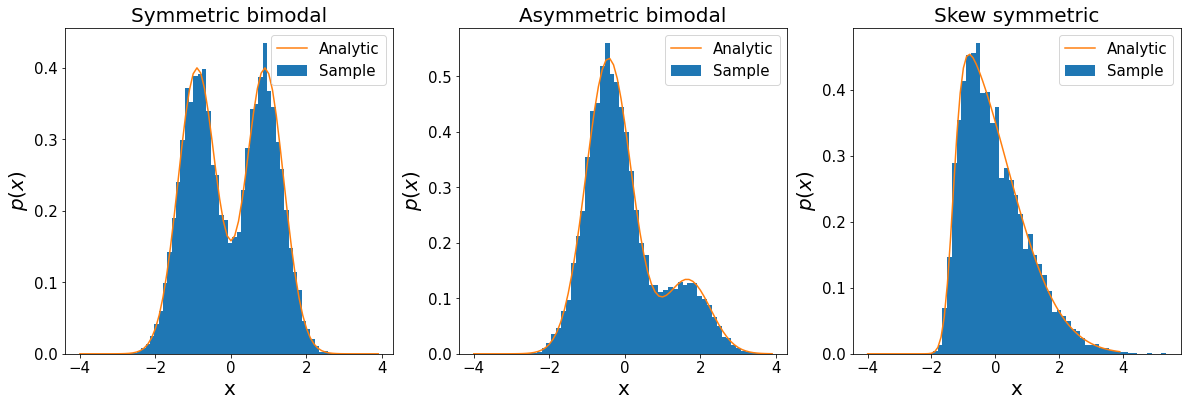

In [4]:
x = np.arange(-4,4,0.1)

fig, ax = plt.subplots(1,3,figsize=[20,6])

for i in range(len(f_test)):
    adata = f_test[i](10000)
    y = f_test_pdf[i](x)
    ax[i].hist(adata,bins=50,density=True)
    ax[i].set_title(names_test[i],fontsize=20)
    ax[i].set_xlabel("x", fontsize=20)
    ax[i].set_ylabel(r"$p(x)$", fontsize=20)
    ax[i].axes.tick_params(labelsize=15)
    ax[i].plot(x,y)
    ax[i].legend(["Analytic","Sample"],fontsize=15,loc="upper right")

fig.show()
fig.savefig("Output/Plots/Test.png",bbox_inches="tight")

## Noise data

Over the test we are going to overlap several noises.

In [5]:
names_noise = ["Normal", "Skew normal", "Bimodal sym", "Bimodal asym",
               "Trimodal sym", "Trimodal asym", "Student", "Laplace", "Laplace sharp"]
f_noise = [data_generator.f_norm, data_generator.f_skew, 
           data_generator.f_bimodal_sym, data_generator.f_bimodal_asym, 
           data_generator.f_trimodal_sym, data_generator.f_trimodal_asym, 
           data_generator.f_student, data_generator.f_laplace, 
           data_generator.f_laplace_sharp]
f_noise_pdf = [data_pdf.f_norm, data_pdf.f_skew, 
           data_pdf.f_bimodal_sym, data_pdf.f_bimodal_asym, 
           data_pdf.f_trimodal_sym, data_pdf.f_trimodal_asym, 
           data_pdf.f_student, data_pdf.f_laplace, 
           data_pdf.f_laplace_sharp]

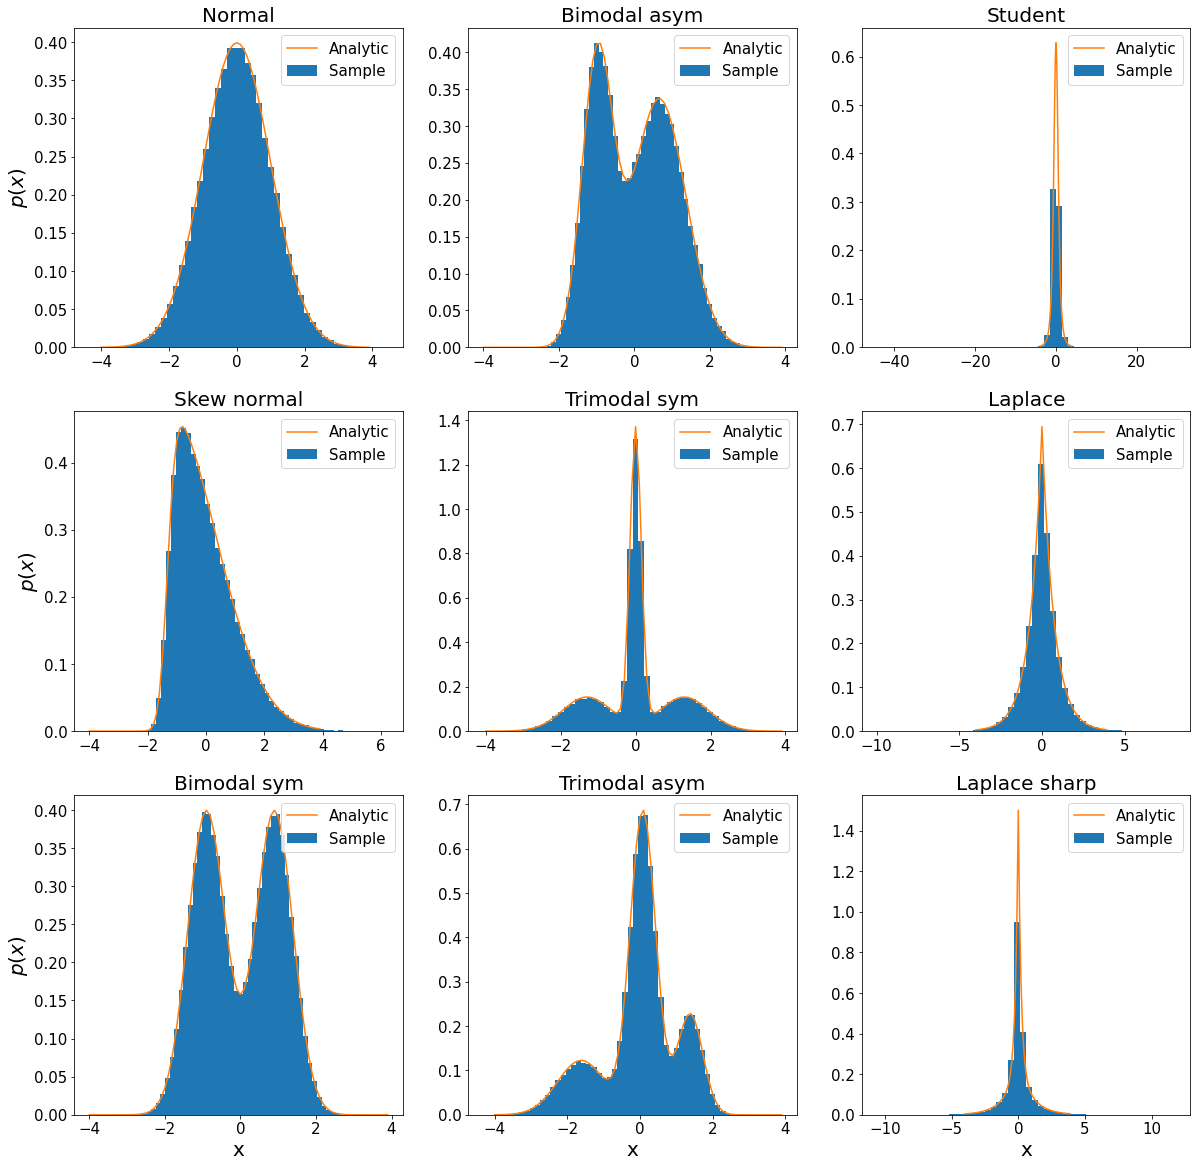

In [6]:
fig, ax = plt.subplots(3,3,figsize=[20,20])
x = np.arange(-4,4,0.1)

for i in range(3):
    for j in range(3):

        adata = f_noise[3*j+i](100000)
        ax[i][j].hist(adata,bins=50,density=True)
        ax[i][j].set_title(names_noise[3*j+i], fontsize=20, loc="center")
        ax[2][j].set_xlabel("x", fontsize=20)
        ax[i][0].set_ylabel(r"$p(x)$", fontsize=20)
        ax[i][j].axes.tick_params(labelsize=15)
        y = f_noise_pdf[3*j+i](x)
        ax[i][j].plot(x,y)
        ax[i][j].legend(["Analytic","Sample"],fontsize=15,loc="upper right")

fig.show()
fig.savefig("Output/Plots/Noise.png",bbox_inches="tight")

## Generation of the datasets

We generate the data for three different orders of magnitude of number of datapoints and the same for signal to noise ratio.

In [7]:
N = [100,1000,10000]
sn = [1,10]

In [8]:
for i_n,i in enumerate(N):
    for j_n,j in enumerate(sn):
        for k_n,k in enumerate(f_test):
            for l_n,l in enumerate(f_noise):
                data_deconv = f_test[k_n](i)
                data_noise = f_noise[l_n](i)/j               #Reduce by the corresponding factor!!!
                data_conv = f_test[k_n](i)+f_noise[l_n](i)/j #Reduce by the corresponding factor!!!
                
                path = "Data/Synthetic/N" + str(i) + "_sn" + str(j) + "_test" + str(k_n+1) + "_" + names_noise[l_n] + ".pkl"
                
                with open(path, "wb") as fil:
                    pk.dump({"Real":data_deconv, "Autofluorescence":data_noise, "Convolution":data_conv}, fil)
                    

## Evaluation of the datasets

Now we will evaluate the datasets and compare them using MISE and AISE metrics.

In [9]:
if False:

    #Make pandas
    evaluation_table = pd.DataFrame(columns=["Test","Noise","N","SNR"])

    model = gd.mcmcsamplernorm(K=5,Kc=5)
    model2 = gd.nestedsamplernorm(K=3,Kc=3)

    dx = 0.1
    x = np.arange(-100,100,dx)

    Neval = N
    sneval = sn
    testeval = f_test
    noiseeval = f_noise

    #Make progress bar and show
    f = IntProgress(min=0, max=len(Neval)*len(sneval)*len(testeval)*len(noiseeval)) # instantiate the bar
    display(f)
    #Make the computations for the Gaussian deconvolution method
    for i_n,i in enumerate(Neval[:1]):
        for j_n,j in enumerate(sneval[1:]):
            for k_n,k in enumerate(testeval):
                for l_n,l in enumerate(noiseeval[:3]):
                    path = "Data/Synthetic/N" + str(i) + "_sn" + str(j) + "_test" + str(k_n+1) + "_" + names_noise[l_n] + ".pkl"
                    
                    with open(path, "rb") as fil:
                        data = pk.load(fil)
                                    
                    score_real = f_test_pdf[k_n](x)

                    model.fit(data["Autofluorescence"],data["Convolution"],ignored_iterations=1000,iterations=5000,chains=4, show_progress=False)
                    score = model.score_deconvolution(x)
                    mise = MISE(score[0],score_real,dx)
                    aise = AISE(score[0],score_real,dx)

                    model2.fit(data["Autofluorescence"],data["Convolution"])
                    score2 = model.score_deconvolution(x)
                    mise2 = MISE(score2[0],score_real,dx)
                    aise2 = AISE(score2[0],score_real,dx)

                    score_FFT = FT_deconv(data["Autofluorescence"],data["Convolution"])
                    miseFFT = MISE(score_real,np.real(score_FFT[0]),dx)
                    aiseFFT = AISE(score_real,np.real(score_FFT[0]),dx)
                    
                    f.value += 1
                    
                    evaluation_table = evaluation_table.append({"Test":k_n,
                                            "Noise":names_noise[l_n],
                                            "N":i,
                                            "SNR":j,
                                            "MISE MCMC":mise,
                                            "MISE Nested":mise2,
                                            "MISE FFT":miseFFT,

                                            "AISE MCMC":aise,
                                            "AISE Nested":aise2,
                                            "AISE FFT":aiseFFT},
                                            ignore_index=True)

    #Save the data

    evaluation_table.to_csv("Output/Tables/Synthetic_data_scores.csv")

else:

    evaluation_table = pd.read_csv("Output/Tables/Synthetic_data_scores.csv")

# Real dataset 1: Artificial convolution of two color channels

## Two color channels

In [10]:
loadmat("Data/Real_1_multichannel/20191030_FITCA.mat")["Conditions"]

array([[array(['20191030-1_Bra Act+Chi_P3'], dtype='<U25'),
        array(['20191030-1_Bra Act_P3'], dtype='<U21'),
        array(['20191030-1_Bra Chi_P3'], dtype='<U21'),
        array(['20191030-1_Bra DMSO_P3'], dtype='<U22'),
        array(['20191030-1_WT DMSO_P3'], dtype='<U21'),
        array(['20191030-1_WT_P3'], dtype='<U16'),
        array(['20191030-2_Bra Act+Chi_P3'], dtype='<U25'),
        array(['20191030-2_Bra Act_P3'], dtype='<U21'),
        array(['20191030-2_Bra Chi_P3'], dtype='<U21'),
        array(['20191030-2_Bra DMSO_P3'], dtype='<U22'),
        array(['20191030-2_WT DMSO_P3'], dtype='<U21'),
        array(['20191030-2_WT_P3'], dtype='<U16')]], dtype=object)

In [11]:
channel1 = loadmat("Data/Real_1_multichannel/20191030_FITCA.mat")["intensity"][:,0]
channel1c = loadmat("Data/Real_1_multichannel/20191030_FITCA.mat")["intensity"][:,6]
channel2 = loadmat("Data/Real_1_multichannel/20191030_PerCP-Cy5-5-A.mat")["intensity"][:,0]
channel2c = loadmat("Data/Real_1_multichannel/20191030_PerCP-Cy5-5-A.mat")["intensity"][:,6]

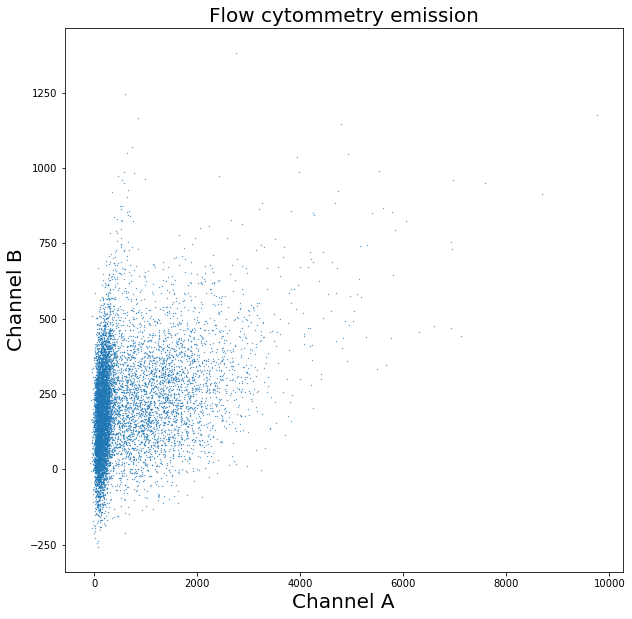

In [12]:
fig,ax = plt.subplots(1,1,figsize=[10,10])
ax.scatter(channel1,channel2,s=0.1)
ax.set_title("Flow cytommetry emission",fontsize=20)
ax.set_xlabel("Channel A",fontsize=20)
ax.set_ylabel("Channel B",fontsize=20)

fig.savefig("Output/Plots/RealDataset1_scatterplot.png",bbox_inches="tight")

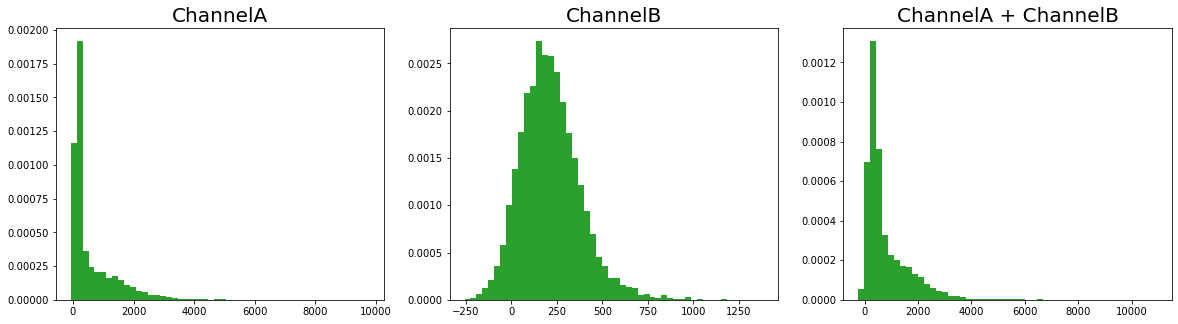

In [13]:
fig,ax = plt.subplots(1,3,figsize=[20,5])
ax[0].hist(channel1,bins=50,density=True,label="convolution")
ax[0].hist(channel1,bins=50,density=True,label="convolution")
ax[0].hist(channel1,bins=50,density=True,label="convolution")
ax[0].set_title("ChannelA",fontsize=20)

ax[1].hist(channel2,bins=50,density=True,label="convolution")
ax[1].hist(channel2,bins=50,density=True,label="convolution")
ax[1].hist(channel2,bins=50,density=True,label="convolution")
ax[1].set_title("ChannelB",fontsize=20)

ax[2].hist(channel1+channel2,bins=50,density=True,label="convolution")
ax[2].hist(channel1+channel2,bins=50,density=True,label="convolution")
ax[2].hist(channel1+channel2,bins=50,density=True,label="convolution")
ax[2].set_title("ChannelA + ChannelB",fontsize=20)

fig.show()
fig.savefig("Output/Plots/RealDataset1_dists.png",bbox_inches="tight")

### Fit with mcmc model

In [14]:
modelmcmc = [gd.mcmcsamplernorm(1,2) for i in range(3)]

if recompute:
    for i in range(3):
        modelmcmc[i].fit(channel2c[i*3000:(i+1)*3000],channel1[i*3000:(i+1)*3000]+channel2[i*3000:(i+1)*3000],ignored_iterations=4000,chains=4,show_progress=False)
        modelmcmc[i].save("Output/Samples/RealDataset1_mcmc_normal"+str(i))
else:
    for i in range(3):
        modelmcmc[i].load("Output/Samples/RealDataset1_mcmc_normal"+str(i))

### Fit with nested model

In [15]:
modelnested = [gd.nestedsamplernorm(1,2) for i in range(3)]
if recompute:
    for i in range(3):
        modelnested[i].fit(channel2c[i*3000:(i+1)*3000],channel1[i*3000:(i+1)*3000]+channel2[i*3000:(i+1)*3000])
        modelnested[i].save("Output/Samples/RealDataset1_nested_normal"+str(i))
else:
    for i in range(3):
        modelnested[i].load("Output/Samples/RealDataset1_nested_normal"+str(i))

### Fit with mcmc gammas

In [18]:
modelmcmcgamma = [gd.mcmcsamplergamma(1,2) for i in range(3)]

if recompute:
    for i in range(3):
        modelmcmcgamma[i].fit(channel2c[i*3000:(i+1)*3000]+280,channel1[i*3000:(i+1)*3000]+channel2[i*3000:(i+1)*3000]+280+280,bias=0,ignored_iterations=4000,iterations=1000,chains=4,show_progress=False)
        modelmcmcgamma[i].save("Output/Samples/RealDataset1_mcmc_gamma"+str(i))
else:
    for i in range(3):
        modelmcmcgamma[i].load("Output/Samples/RealDataset1_mcmc_gamma"+str(i))

### Fit with nested gammas

In [19]:
modelnestedgamma = [gd.nestedsamplergamma(1,2) for i in range(3)]

if recompute:
    for i in range(3):
        modelnestedgamma[i].fit(channel2c[i*3000:(i+1)*3000],channel1[i*3000:(i+1)*3000]+channel2[i*3000:(i+1)*3000],bias=-280)
        modelnestedgamma[i].save("Output/Samples/RealDataset1_nested_gamma"+str(i))
else:
    for i in range(3):
        modelnestedgamma[i].load("Output/Samples/RealDataset1_nested_gamma"+str(i))


## Plot deconvolution

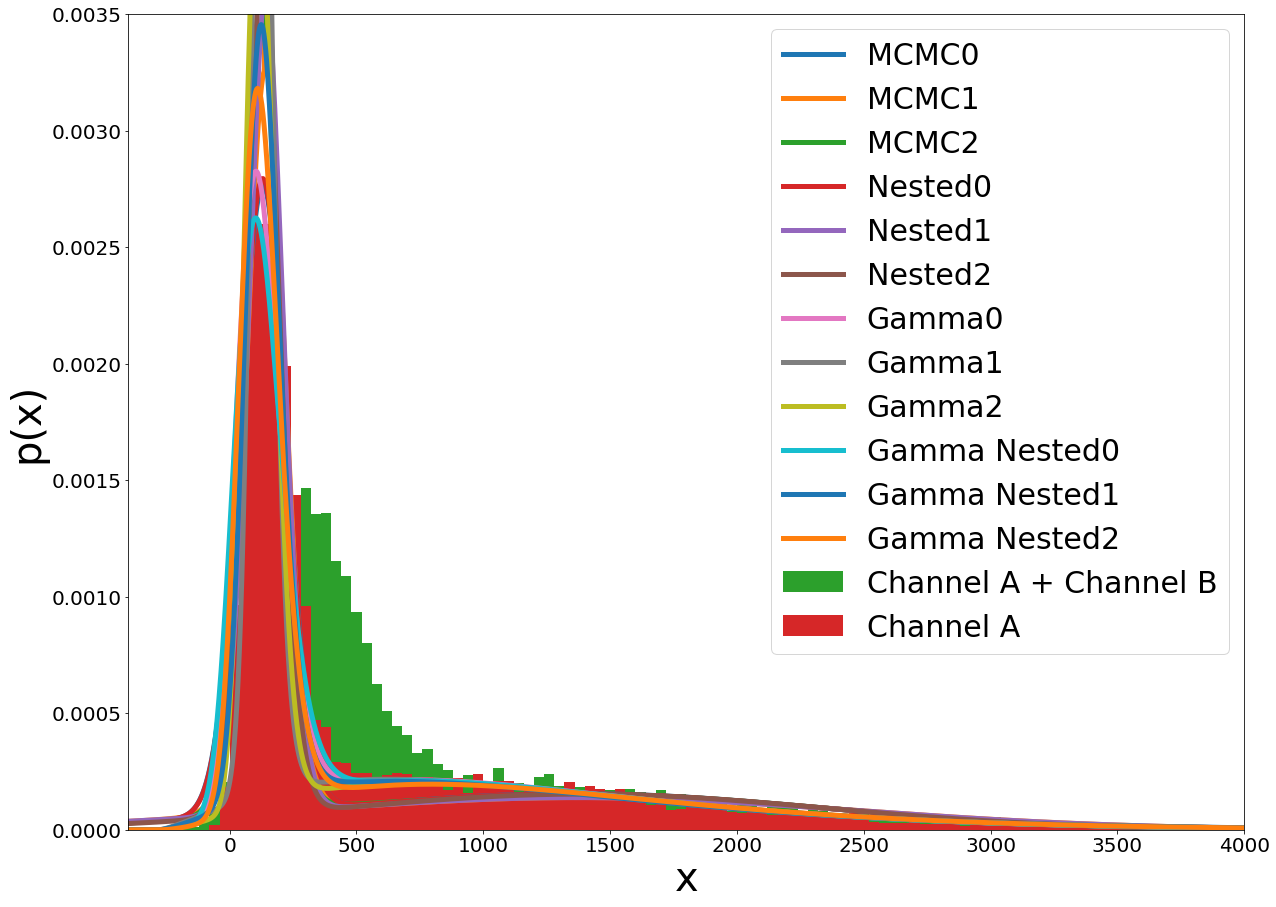

In [20]:
plt.figure(figsize=[20,15])

x = np.arange(-400,10000,1)
xh = np.arange(-400,10000,40)
for j,i in enumerate(modelmcmc):
    y = i.score_deconvolution(x)
    plt.plot(x,y[0],label="MCMC"+str(j),linewidth=5)
    #plt.fill_between(x,y[1],y2=y[2],alpha=0.2)

for j,i in enumerate(modelnested):
    y = i.score_deconvolution(x)
    plt.plot(x,y[0],label="Nested"+str(j),linewidth=5)
    #plt.fill_between(x,y[1],y2=y[2],alpha=0.2)

for j,i in enumerate(modelmcmcgamma):
    y = i.score_deconvolution(x)
    plt.plot(x-280,y[0],label="Gamma"+str(j),linewidth=5)
    #plt.fill_between(x,y[1],y2=y[2],alpha=0.2)

for j,i in enumerate(modelnestedgamma):
    y = i.score_deconvolution(x)
    plt.plot(x-280,y[0],label="Gamma Nested"+str(j),linewidth=5)
    #plt.fill_between(x,y[1],y2=y[2],alpha=0.2)
    
plt.hist(channel1+channel2,bins=xh,density=True,label="Channel A + Channel B")
plt.hist(channel1,bins=xh,density=True,label="Channel A")
plt.legend(fontsize=30)
plt.axis([-400,4000,0,0.0035])
plt.tick_params(labelsize=20)
plt.xlabel("x",fontsize=40)
plt.ylabel("p(x)",fontsize=40)
plt.savefig("Output/Plots/Twochannels.png",bbox_inches="tight")
plt.show()

## Results

### KS distance

In [24]:
kbase = st.ks_2samp(channel1,channel1+channel2-np.mean(channel1))[0]

y0 = []
for j,i in enumerate(modelmcmc):
    y = []
    for k in range(20):
        sample = i.sample_deconvolution(3000,style="single")
        y.append(st.ks_2samp(channel1,sample)[0])
    y0.append(y)
    
columns=["MCMC"+str(i) for i in range(3)]
    
for j,i in enumerate(modelnested):
    y = []
    for k in range(20):
        sample = i.sample_deconvolution(3000,style="single")
        y.append(st.ks_2samp(channel1,sample)[0])
    y0.append(y)
    
columns = columns+["Nested"+str(i) for i in range(3)]

for j,i in enumerate(modelmcmcgamma):
    y = []
    for k in range(20):
        sample = i.sample_deconvolution(3000,style="single")-280
        y.append(st.ks_2samp(channel1,sample)[0])
    y0.append(y)
    
columns = columns+["MCMCGamma"+str(i) for i in range(3)]

for j,i in enumerate(modelnestedgamma):
    y = []
    for k in range(20):
        sample = i.sample_deconvolution(3000,style="single")
        y.append(st.ks_2samp(channel1,sample)[0])
    y0.append(y)
    
columns = columns+["NestedGamma"+str(i) for i in range(3)]

In [25]:
ks = pd.DataFrame(y0,index=columns)

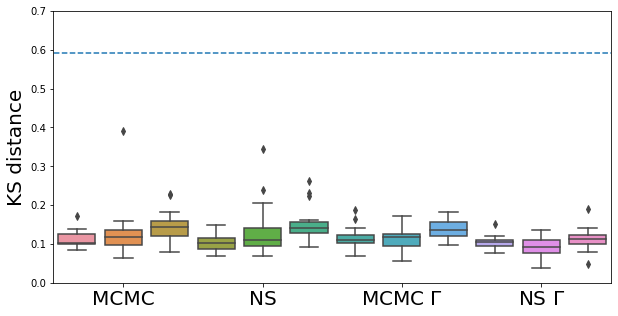

In [43]:
fig,ax=plt.subplots(figsize=[10,5])
sns.boxplot(data=ks.T,ax=ax)
ax.hlines(kbase,xmin=-1,xmax=12,linestyles="--")
ax.set_ylabel("KS distance",fontsize=20)
ax.axis([-0.51,11.51,0,0.7])

ax.set_xticks([1,4,7,10])
ax.set_xticklabels(["MCMC","NS","MCMC $\Gamma$","NS $\Gamma$"],fontsize=20)

fig.savefig("Output/Plots/Real_Dataset_KS_Two_channels.png",bbox_inches="tight")

### MIAE distance

First, we make the fitting to a kernel method.

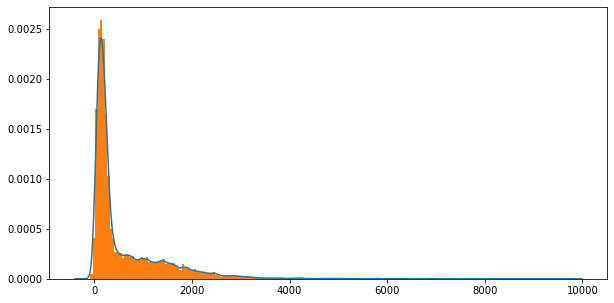

In [29]:
dx=10
x = np.arange(-400,10000,dx)

model = KernelDensity(bandwidth=50)

model.fit(channel1.reshape(-1,1))
deconv = np.exp(model.score_samples(x.reshape(-1,1)))

model.fit((channel1+channel2-np.mean(channel1)).reshape(-1,1))
conv = np.exp(model.score_samples(x.reshape(-1,1)))

fig,ax=plt.subplots(figsize=[10,5])

ax.plot(x,deconv)
ax.hist(channel1,density=True,bins=200)

fig.savefig("Output/Plots/RealDataset_kernel_fit.png",bbox_inches="tight")

In [33]:
miaebase = AISE(deconv,conv,dx)

y0 = []
ym = []
for j,i in enumerate(modelmcmc):
    y = []
    for k in range(50):
        sample = i.score_deconvolution(x,size=1)[0]
        y.append(AISE(deconv,sample,dx))
    y0.append(y)
    sample = i.score_deconvolution(x,size=2000)[0]
    ym.append(AISE(deconv,sample,dx))
    
columns=["MCMC"+str(i) for i in range(3)]
    
for j,i in enumerate(modelnested):
    y = []
    for k in range(50):
        sample = i.score_deconvolution(x,size=1)[0]
        y.append(AISE(deconv,sample,dx))
    y0.append(y)
    sample = i.score_deconvolution(x,size=2000)[0]
    ym.append(AISE(deconv,sample,dx))

columns = columns+["NS"+str(i) for i in range(3)]

for j,i in enumerate(modelmcmcgamma):
    y = []
    for k in range(50):
        sample = np.nan_to_num(i.score_deconvolution(x+280,size=1)[0])
        y.append(AISE(deconv,sample,dx))
    y0.append(y)
    sample = np.nan_to_num(i.score_deconvolution(x+280,size=2000)[0])
    ym.append(AISE(deconv,sample,dx))
    
columns=columns+["MCMC $\Gamma$"+str(i) for i in range(3)]
    
for j,i in enumerate(modelnestedgamma):
    y = []
    for k in range(50):
        sample = np.nan_to_num(i.score_deconvolution(x+280,size=1)[0])
        y.append(AISE(deconv,sample,dx))
    y0.append(y)
    sample = np.nan_to_num(i.score_deconvolution(x+280,size=2000)[0])
    ym.append(AISE(deconv,sample,dx))

columns = columns+["NS $\Gamma$"+str(i) for i in range(3)]

In [34]:
miae = pd.DataFrame(y0,index=columns)

<ipython-input-42-968910cedeee>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(np.arange(0.4,1.1,0.1),1),fontsize=20)


Text(0, 0.5, 'Output/Plots/MIAE.png')

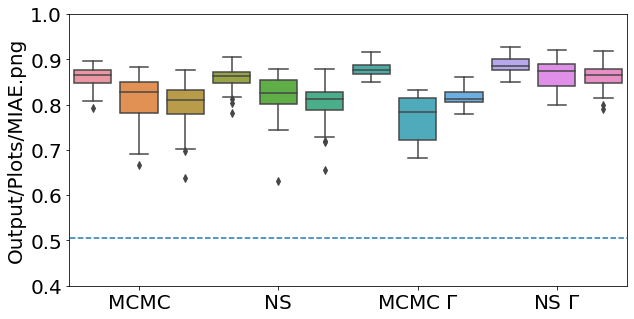

In [42]:
fig,ax=plt.subplots(figsize=[10,5])
sns.boxplot(data=miae.T,ax=ax)
ax.hlines(miaebase,xmin=-1,xmax=12,linestyles="--")
#for i,j in enumerate(ym):
    #ax.hlines(ym[i],xmin=i-0.1,xmax=i+0.1,linestyles="-",linewidth=1)
    #ax.scatter(i,ym[i],s=50,marker="*",c="k",alpha=1)

ax.set_xticks([1,4,7,10])
ax.set_xticklabels(["MCMC","NS","MCMC $\Gamma$","NS $\Gamma$"],fontsize=20)
# ax.set_xticklabels([],fontsize=0)
ax.set_yticklabels(np.round(np.arange(0.4,1.1,0.1),1),fontsize=20)
ax.axis([-0.51,11.51,0.4,1])
ax.set_ylabel("Output/Plots/MIAE.png",fontsize=20)

# Real dataset 2: Experimental convolution

In [193]:
loadmat("Data/Real validation/20200716_FITCA.mat")["Conditions"]

array([[array(['20200716-1_Bra ActChi dye_P3'], dtype='<U28'),
        array(['20200716-1_Bra ActChi no dye_P3'], dtype='<U31'),
        array(['20200716-1_Bra Chi dye_P3'], dtype='<U25'),
        array(['20200716-1_Bra Chi no dye_P3'], dtype='<U28'),
        array(['20200716-1_Bra DMSO dye_P3'], dtype='<U26'),
        array(['20200716-1_Bra DMSO no dye_P3'], dtype='<U29'),
        array(['20200716-2_Bra ActChi dye_P3'], dtype='<U28'),
        array(['20200716-2_Bra ActChi no dye_P3'], dtype='<U31'),
        array(['20200716-2_Bra Chi dye_P3'], dtype='<U25'),
        array(['20200716-2_Bra Chi no dye_P3'], dtype='<U28'),
        array(['20200716-2_Bra DMSO dye_P3'], dtype='<U26'),
        array(['20200716-2_Bra DMSO no dye_P3'], dtype='<U29')]],
      dtype=object)

In [194]:
N = 10000

dataActChiDye = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,0]
dataActChi = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,1]
dataChiDye = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,2]
dataChi = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,3]
dataDye = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,4]
data = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,5]

dataActChiDye2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,6]
dataActChi2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,7]
dataChiDye2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,8]
dataChi2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,9]
dataDye2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,10]
data2 = loadmat("Data/Real validation/20200716_FITCA.mat")["intensity"][:N,11]

mean = 0#np.mean(data)
std = 1#np.std(data)

dataActChiDye = (dataActChiDye-mean)/std
dataActChi = (dataActChi-mean)/std
dataChiDye = (dataChiDye-mean)/std
dataChi = (dataChi-mean)/std
dataDye = (dataDye-mean)/std
data = (data-mean)/std

dataActChiDye2 = (dataActChiDye2-mean)/std
dataActChi2 = (dataActChi2-mean)/std
dataChiDye2 = (dataChiDye2-mean)/std
dataChi2 = (dataChi2-mean)/std
dataDye2 = (dataDye2-mean)/std
data2 = (data2-mean)/std

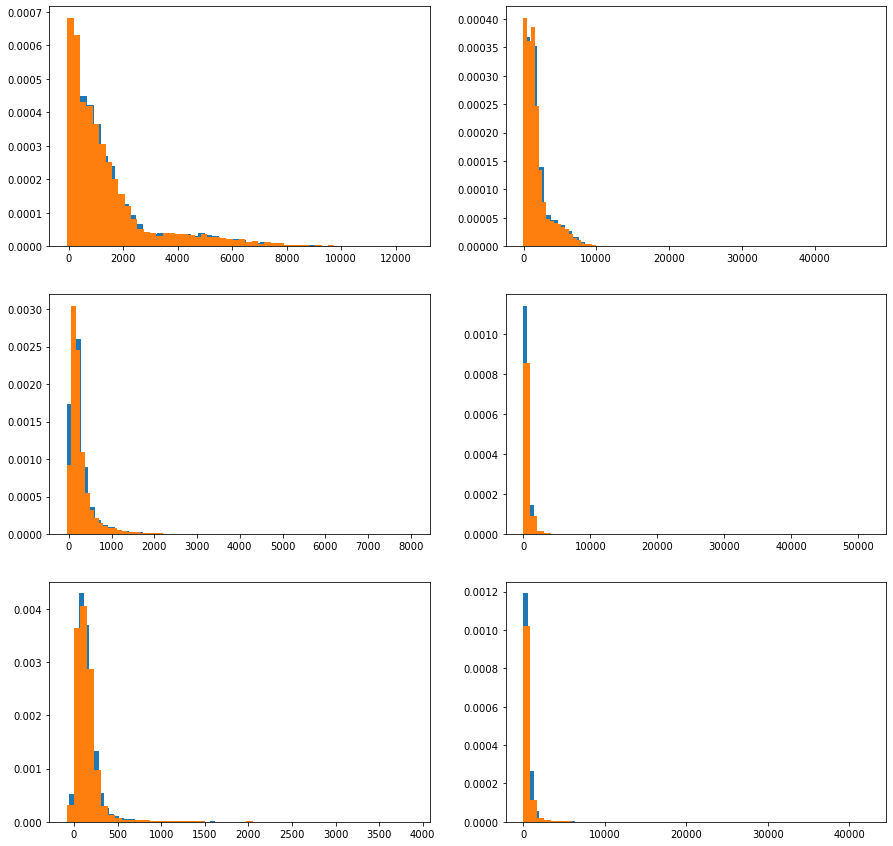

In [195]:
fig,ax = plt.subplots(3,2,figsize=[15,15])

ax[0][0].hist(dataActChi,bins=50,density=True)
ax[0][1].hist(dataActChiDye,bins=50,density=True)

ax[1][0].hist(dataChi,bins=50,density=True)
ax[1][1].hist(dataChiDye,bins=50,density=True)

ax[2][0].hist(data,bins=50,density=True)
ax[2][1].hist(dataDye,bins=50,density=True)

ax[0][0].hist(dataActChi2,bins=50,density=True)
ax[0][1].hist(dataActChiDye2,bins=50,density=True)

ax[1][0].hist(dataChi2,bins=50,density=True)
ax[1][1].hist(dataChiDye2,bins=50,density=True)

ax[2][0].hist(data2,bins=50,density=True)
ax[2][1].hist(dataDye2,bins=50,density=True)

plt.show()

## Fit samplers

Since the flow cytometer returns signals that have negative value, we add a contant value of 100 to all datasets so the parameters lay in the positive axis, where the gamma distributions are defined. Alternatively, we could have added a bias term in the function.

We split the data in three batches in order to check reproducibility of the deconvolutions.

### MCMC gamma

In [196]:
modelgamma = [gd.mcmcsamplergamma(2,3) for i in range(12)]

if True:    

    modelgamma[0].fit(data[:3000]+100,dataDye[:3000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[1].fit(data[3000:6000]+100,dataDye[3000:6000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[2].fit(data[6000:9000]+100,dataDye[6000:9000]+100,ignored_iterations=4000,iterations=4000)

    modelgamma[3].fit(data2[:3000]+100,dataDye2[:3000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[4].fit(data2[3000:6000]+100,dataDye2[3000:6000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[5].fit(data2[6000:9000]+100,dataDye2[6000:9000]+100,ignored_iterations=4000,iterations=4000)

    modelgamma[6].fit(dataChi[:3000]+100,dataChiDye[:3000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[7].fit(dataChi[3000:6000]+100,dataChiDye[3000:6000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[8].fit(dataChi[6000:9000]+100,dataChiDye[6000:9000]+100,ignored_iterations=4000,iterations=4000)

    modelgamma[9].fit(dataChi2[:3000]+100,dataChiDye2[:3000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[10].fit(dataChi2[3000:6000]+100,dataChiDye2[3000:6000]+100,ignored_iterations=4000,iterations=4000)
    modelgamma[11].fit(dataChi2[6000:9000]+100,dataChiDye2[6000:9000]+100,ignored_iterations=4000,iterations=4000)

else:

    modelgamma[0].load()

Chain 0  Ignorable iterations:  0 %
Chain 0  Ignorable iterations:  10 %
Chain 0  Ignorable iterations:  20 %
Chain 0  Ignorable iterations:  30 %
Chain 0  Ignorable iterations:  40 %
Chain 0  Ignorable iterations:  50 %
Chain 0  Ignorable iterations:  60 %
Chain 0  Ignorable iterations:  70 %
Chain 0  Ignorable iterations:  80 %
Chain 0  Ignorable iterations:  90 %
Chain 0  Ignorable iterations: 100%
Chain 0  Recorded iterations:  0 %
Chain 0  Recorded iterations:  10 %
Chain 0  Recorded iterations:  20 %
Chain 0  Recorded iterations:  30 %
Chain 0  Recorded iterations:  40 %
Chain 0  Recorded iterations:  50 %
Chain 0  Recorded iterations:  60 %
Chain 0  Recorded iterations:  70 %
Chain 0  Recorded iterations:  80 %
Chain 0  Recorded iterations:  90 %
Chain 0  Recorded iterations: 100%
Chain 0  Ignorable iterations:  0 %
Chain 0  Ignorable iterations:  10 %
Chain 0  Ignorable iterations:  20 %
Chain 0  Ignorable iterations:  30 %
Chain 0  Ignorable iterations:  40 %
Chain 0  Ignorabl

In [199]:
modelgammanested = [gd.nestedsamplergamma(2,3) for i in range(12)]

modelgammanested[0].fit(data[:3000]+100,dataDye[:3000]+100)
modelgammanested[1].fit(data[3000:6000]+100,dataDye[3000:6000]+100)
modelgammanested[2].fit(data[6000:9000]+100,dataDye[6000:9000]+100)

modelgammanested[3].fit(data2[:3000]+100,dataDye2[:3000]+100)
modelgammanested[4].fit(data2[3000:6000]+100,dataDye2[3000:6000]+100)
modelgammanested[5].fit(data2[6000:9000]+100,dataDye2[6000:9000]+100)

modelgammanested[6].fit(dataChi[:3000]+100,dataChiDye[:3000]+100)
modelgammanested[7].fit(dataChi[3000:6000]+100,dataChiDye[3000:6000]+100)
modelgammanested[8].fit(dataChi[6000:9000]+100,dataChiDye[6000:9000]+100)

modelgammanested[9].fit(dataChi2[:3000]+100,dataChiDye2[:3000]+100)
modelgammanested[10].fit(dataChi2[3000:6000]+100,dataChiDye2[3000:6000]+100)
modelgammanested[11].fit(dataChi2[6000:9000]+100,dataChiDye2[6000:9000]+100)

19650it [07:26, 44.00it/s, +500 | bound: 101 | nc: 1 | ncall: 510551 | eff(%):  3.947 | loglstar:   -inf < -39359.942 <    inf | logz: -39398.639 +/-  0.402 | dlogz:  0.001 >  0.509]
18345it [06:51, 41.61it/s, bound: 105 | nc: 26 | ncall: 481389 | eff(%):  3.811 | loglstar:   -inf < -39474.458 <    inf | logz: -39510.899 +/-  0.373 | dlogz:  5.995 >  0.509]Traceback (most recent call last):
  File "/home/gabriel/.local/lib/python3.9/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
KeyboardInterrupt
18347it [06:51, 44.56it/s, bound: 105 | nc: 33 | ncall: 481449 | eff(%):  3.811 | loglstar:   -inf < -39474.432 <    inf | logz: -39510.895 +/-  0.373 | dlogz:  5.987 >  0.509]

Exception while calling loglikelihood function:
  params: [9.62249951e-01 3.77500488e-02 3.31526602e+01 2.56344996e+02
 7.02425577e+00 2.93631612e+00 2.04602658e-01 7.63613386e-01
 3.17839559e-02 2.57795890e+02 8.93481439e+01 2.49358955e+03
 2.46587155e+00 2.33960737e+00 1.34892602e+00]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Plot deconvolutions

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


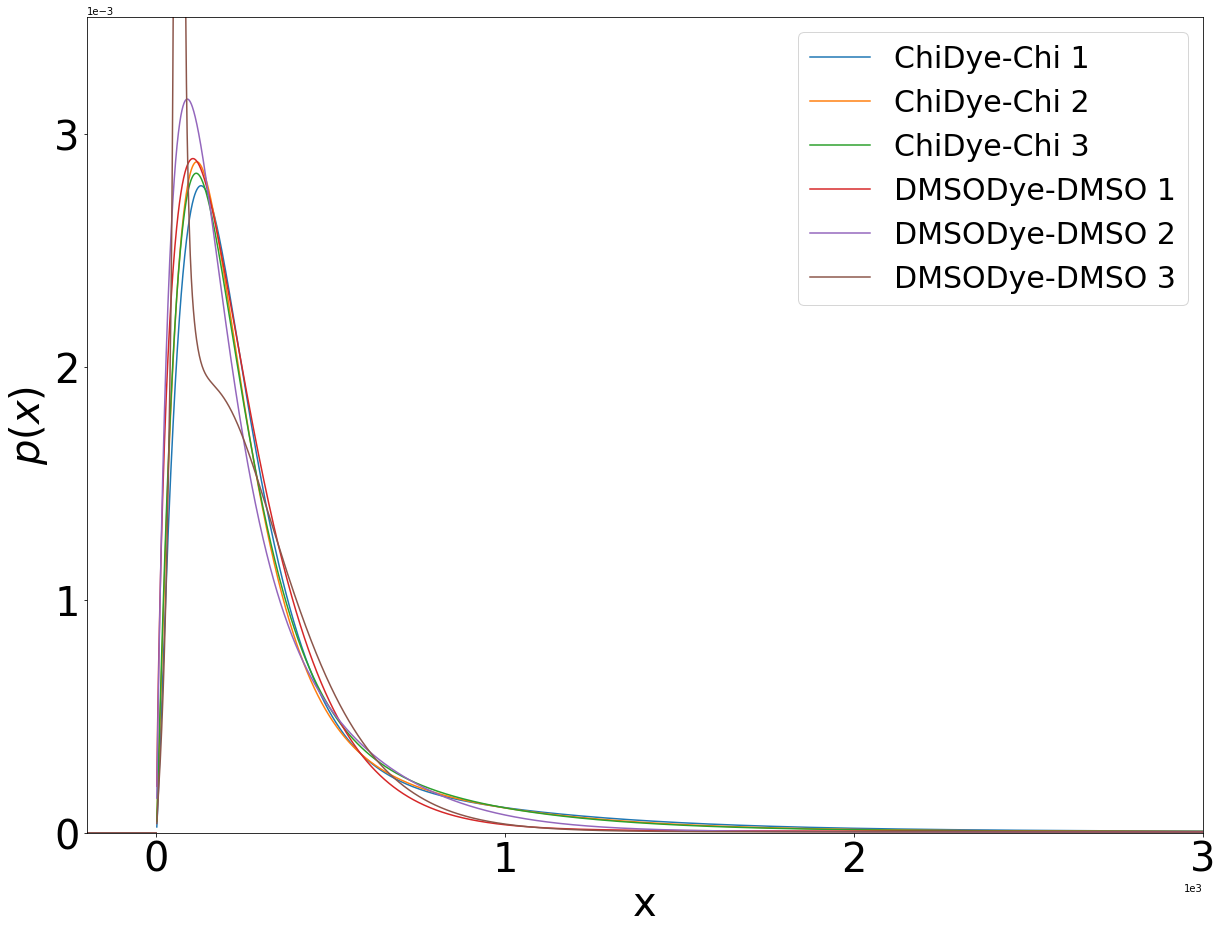

In [197]:
plt.figure(figsize=[20,15])

x = np.arange(-200,3000,1)
for i in [0,1,2,6,7,8]:
    #plt.hist(model[i].sample_deconvolution(20000),bins=x,density=True,histtype='step')
    plt.plot(x,modelgamma[i].score_deconvolution(x,size=200)[0])
    #plt.plot(x,modelgamma[i].score_deconvolution(x,size=200)[0])
        
plt.axis([-200,3000,0,0.0035])

plt.ticklabel_format(scilimits=(-1,2))
plt.xlabel("x",fontsize=40)
plt.xticks([0,1000,2000,3000],fontsize=40)

plt.ylabel("$p(x)$",fontsize=40)
plt.yticks([0,1e-3,0.002,0.003],fontsize=40)

plt.legend(["ChiDye-Chi 1","ChiDye-Chi 2","ChiDye-Chi 3", "DMSODye-DMSO 1", "DMSODye-DMSO 2", "DMSODye-DMSO 3"],fontsize=30)

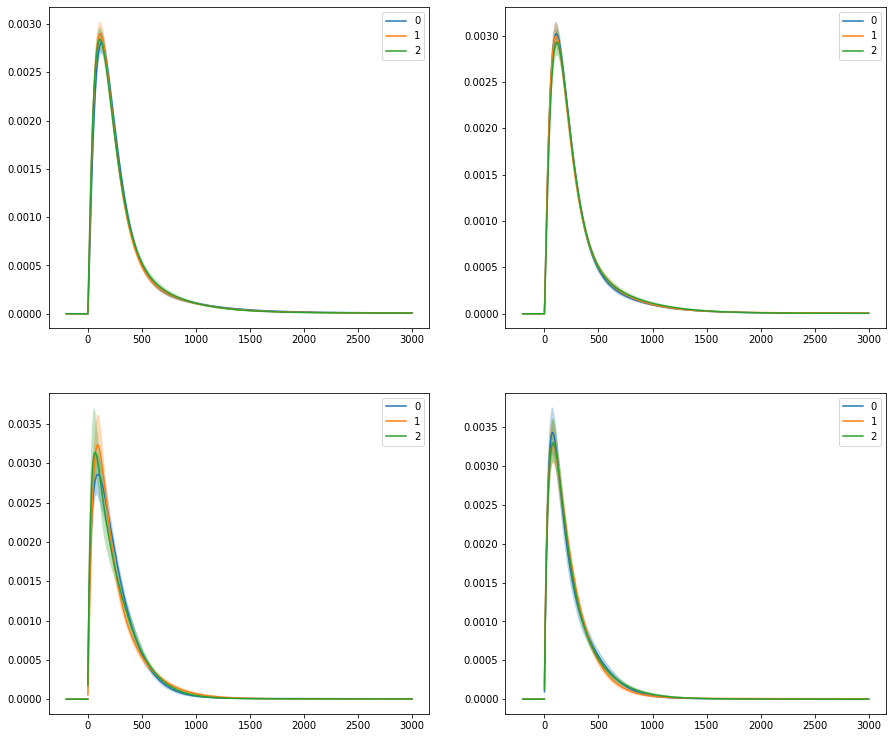

In [ ]:
x = np.arange(-200,3000,0.5)
fig,ax=plt.subplots(2,2,figsize=[15,13])
for i in range(0,2):
    for j in range(0,2):
        for k in range(0,3):
            y = modelgammanested[3*(i*2+j)+k].score_deconvolution(x,size=2000)
            ax[i,j].plot(x,y[0],label=k)
            ax[i,j].fill_between(x,y[1][0],y2=y[1][1],alpha=0.3)
        ax[i,j].legend()

#plt.hist(dataDye[3000:6000], bins=250, density=True)
#plt.axis([-5,15,0,0.6])
plt.show()

## Consistency deconvolution

In [114]:
modelgamma0 = [gd.nestedsamplergamma() for i in range(6)]
for i in range(6):
    modelgamma0[i].load("Model without label/gammaconsistency"+str(i))

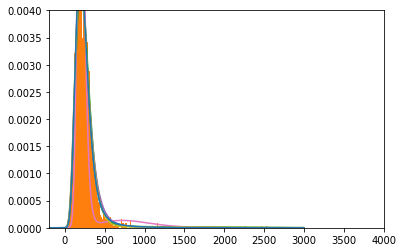

In [115]:
x = np.arange(-200,3000,1)
for i in range(6):
    #plt.hist(model[i].sample_deconvolution(20000),bins=x,density=True,histtype='step')
    plt.plot(x,modelgamma0[i].score_deconvolution(x,size=200)[0])
    plt.hist(data[:3000]+100,density=True, bins =300)
    
plt.axis([-200,4000,0,0.004])
plt.show()

## Deconvolve from noise

In [108]:
modelgamma2 = [gd.nestedsamplergamma() for i in range(6)]
for i in range(6):
    modelgamma2[i].load("Model without label/deconvolution2"+str(i))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


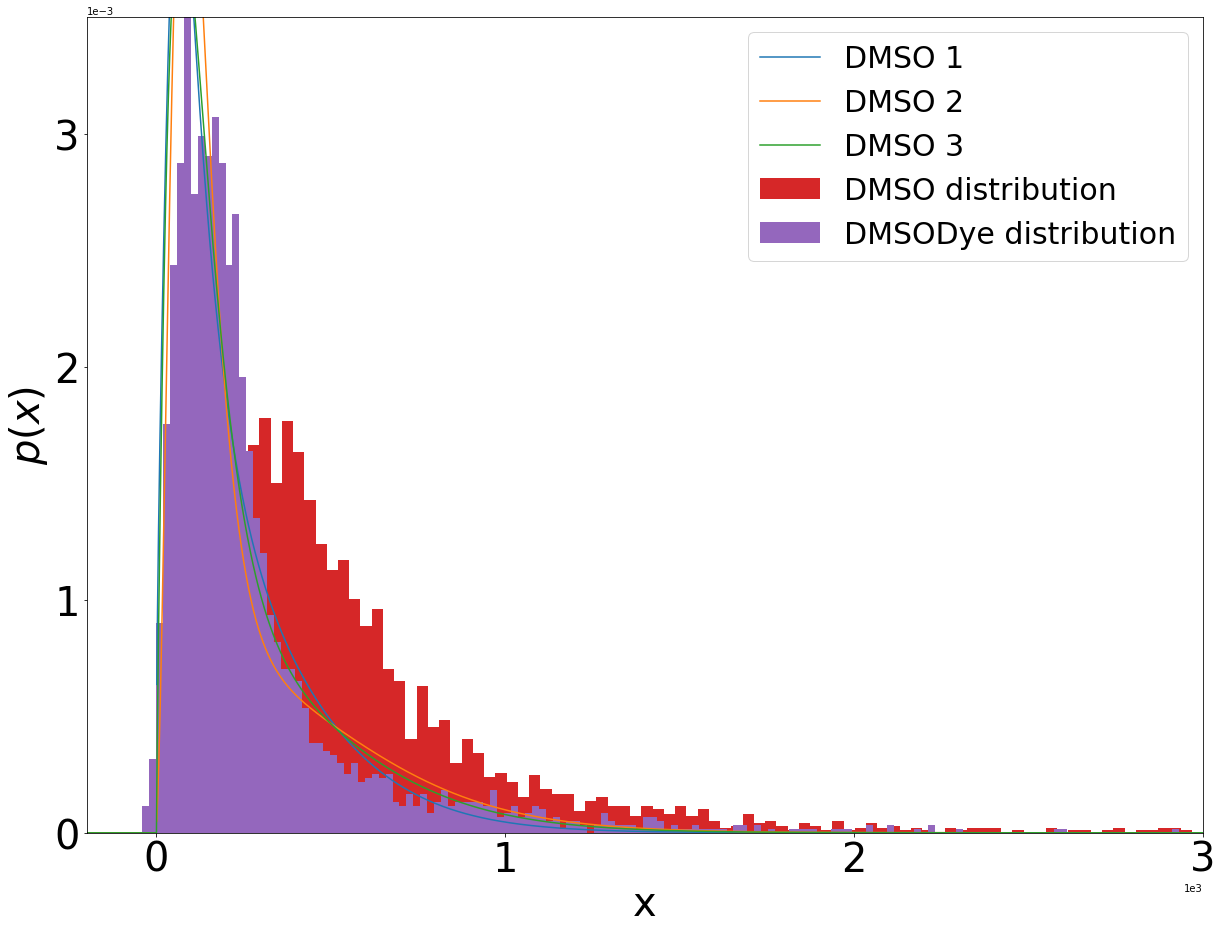

In [117]:
plt.figure(figsize=[20,15])

x = np.arange(-200,3000,1)
for i in range(3):
    #plt.hist(model[i].sample_deconvolution(20000),bins=x,density=True,histtype='step')
    y = modelgamma2[i].score_deconvolution(x,size=200)
    plt.plot(x,y[0])
    #plt.fill_between(x,y[1][0],y2=y[1][1],alpha=0.3)

plt.hist(dataChiDye[:3000],density=True, bins =300)
plt.hist(dataChi[:3000],density=True, bins =200)
        
plt.axis([-200,3000,0,0.0035])

plt.ticklabel_format(scilimits=(-1,2))
plt.xlabel("x",fontsize=40)
plt.xticks([0,1000,2000,3000],fontsize=40)

plt.ylabel("$p(x)$",fontsize=40)
plt.yticks([0,1e-3,0.002,0.003],fontsize=40)

plt.legend(["DMSO 1","DMSO 2","DMSO 3", "DMSO distribution", "DMSODye distribution"],fontsize=30)

plt.savefig("Deconvolution.eps",bbox_inches="tight")

In [123]:
dx=10
x = np.arange(-400,10000,dx)

model = KernelDensity(bandwidth=50)

model.fit(dataChi[:3000].reshape(-1,1))
deconv = np.exp(model.score_samples(x.reshape(-1,1)))

model.fit(dataChiDye[:3000].reshape(-1,1))
conv = np.exp(model.score_samples(x.reshape(-1,1)))

sample = modelgamma2[1].score_deconvolution(x,size=1)[0]
print(AISE(deconv,sample,dx))

print(AISE(deconv,conv,dx))

0.8141019411377381
0.5408354654886651
